# 0、导包与数据生成

In [0]:
# coding=utf8
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [0]:
'''创建训练的数据集'''
centers = [(-5, -5), (0, 0), (5, 5)]
n_samples=50000
data, target = make_blobs(n_samples=n_samples, centers=centers, random_state=0, cluster_std=0.60,shuffle=False)

target[:n_samples // 2] = 0
target[n_samples // 2:] = 1

'''模型融合中使用到的各个单模型'''
clfs = [RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

'''切分一部分数据作为测试集'''
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.33, random_state=2020)

In [3]:
data,target

(array([[-3.94156859, -4.75990567],
        [-4.41275721, -3.65546408],
        [-3.87946521, -5.58636673],
        ...,
        [ 5.43203464,  4.79737114],
        [ 3.78287094,  5.43570919],
        [ 4.29930169,  4.22887541]]), array([0, 0, 0, ..., 1, 1, 1]))

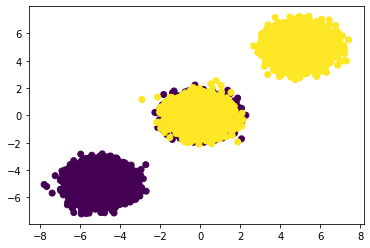

In [4]:
plt.scatter(data[:,0],data[:,1],c=target)

# 1、Stacking方法

1、将数据划分为训练集和测试集(test_set)，对训练集进行划分为K个大小相似的集合，取其中一份作为验证集val_set,其余的为训练集train_set；

2、创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
对于每一个模型来说，train_set和val_set是不一样的，如图所示；

3、然后利用各自的train_set训练各自的模型，训练好的模型对各自的val_set和test_set进行预测，得到val_predict和test_predict（相当于新的特征）；

4、创建第二层的模型（对新的特征进行预测），将每个模型对应的val_predict拼接起来作为第二层的训练集，将所有模型的test_predict取平均值作为第二层的测试集；用训练好的第二层模型对第二层的测试集进行预测，得到的结果即为整个测试集的结果

![替代文字](https://img-blog.csdnimg.cn/20190521095858105.png)

In [0]:
'''用于存储每个模型预测出来的结果'''
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))#X.shape[0]表示训练数据的行数，len(clfs)表示每一列为一个模型的预测结果
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

In [6]:
'''5折stacking'''
n_folds = 5
skf=StratifiedKFold(n_folds,shuffle=True,random_state=2020)
folds = list(skf.split(X,y))
folds

[(array([    0,     1,     3, ..., 33497, 33498, 33499]),
  array([    2,     4,    27, ..., 33485, 33490, 33493])),
 (array([    1,     2,     4, ..., 33497, 33498, 33499]),
  array([    0,     3,    13, ..., 33484, 33492, 33494])),
 (array([    0,     1,     2, ..., 33495, 33496, 33497]),
  array([    7,    15,    17, ..., 33491, 33498, 33499])),
 (array([    0,     1,     2, ..., 33497, 33498, 33499]),
  array([   10,    11,    14, ..., 33483, 33487, 33496])),
 (array([    0,     2,     3, ..., 33496, 33498, 33499]),
  array([    1,     5,     6, ..., 33489, 33495, 33497]))]

In [7]:
for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    # print(j, clf)
    dataset_blend_test_j = np.zeros((X_predict.shape[0], len(folds)))#
    for i, (train, test) in enumerate(folds):
        '''使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。'''
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        #利用当前模型使用的部分数据对另一份数据进行预测——验证
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        #对原始数据集上的测试集处理
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("model %d test auc Score : %f" % (j,roc_auc_score(y_predict, dataset_blend_test[:, j])))

model 0 test auc Score : 0.943510
model 1 test auc Score : 0.943105
model 2 test auc Score : 0.943517
model 3 test auc Score : 0.944091
model 4 test auc Score : 0.942587


In [8]:
dataset_blend_train,dataset_blend_train.shape,len(y)

(array([[1.        , 1.        , 1.        , 1.        , 0.61127109],
        [1.        , 1.        , 1.        , 1.        , 0.61127109],
        [0.        , 0.        , 0.        , 0.        , 0.38600915],
        ...,
        [1.        , 1.        , 1.        , 1.        , 0.61127109],
        [1.        , 1.        , 1.        , 1.        , 0.61127128],
        [1.        , 1.        , 1.        , 1.        , 0.61127128]]),
 (33500, 5),
 33500)

In [9]:
#使用融合的模型对新的特征进行预测
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_blend_train, y)#新特征的处理
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]#预测概率

#对测试集处理
print("Linear stretch of predictions to [0,1]")
y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
print("blend result")
print("ensemble model test auc Score: %f" % (roc_auc_score(y_predict, y_submission)))

Linear stretch of predictions to [0,1]
blend result
ensemble model test auc Score: 0.942864


# 2、Blending方法

1、将数据划分为训练集和测试集(test_set)，其中训练集需要再次划分为训练集(train_set)和验证集(val_set)；

2、创建第一层的多个模型，这些模型可以使同质的也可以是异质的；

3、使用train_set训练步骤2中的多个模型，然后用训练好的模型预测val_set和test_set得到val_predict, test_predict；

4、创建第二层的模型,使用val_predict作为训练集训练第二层的模型；

5、使用第二层训练好的模型对第二层测试集test_predict1进行预测，该结果为整个测试集的结果

![image.png](https://img-blog.csdnimg.cn/2019052109512454.png)


In [10]:
'''切分训练数据集为d1,d2两部分'''
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=2017)
dataset_d1 = np.zeros((X_d1.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))

for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    '''使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。'''
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]#原始数据的测试
    print("model %d test auc Score: %f" % (j,roc_auc_score(y_predict, dataset_d2[:, j])))

'''融合使用的模型'''
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]

print("Linear stretch of predictions to [0,1]")
y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
print("blend result")
print("ensemble model test auc Score: %f" % (roc_auc_score(y_predict, y_submission)))


model 0 test auc Score: 0.922649
model 1 test auc Score: 0.923164
model 2 test auc Score: 0.920814
model 3 test auc Score: 0.922355
model 4 test auc Score: 0.942720
Linear stretch of predictions to [0,1]
blend result
ensemble model test auc Score: 0.943607


Blending的优点在于：

1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）

2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集

3.在团队建模过程中，不需要给队友分享自己的随机种子



而缺点在于：

1.使用了很少的数据（是划分hold-out作为测试集，并非cv）

2.blender可能会过拟合（其实大概率是第一点导致的）

3.stacking使用多次的CV会比较稳健